Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [75]:
import random
from random import choices
from copy import copy
import numpy as np
import lab9_lib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from colorama import Fore, Style


# Local Search:
Local search is a heuristic method for solving computationally hard optimization problems. Local search can be used on problems that can be formulated as finding a solution maximizing a criterion among a number of candidate solutions. Local search algorithms move from solution to solution in the space of candidate solutions (the search space) by applying local changes, until a solution deemed optimal is found or a time bound is elapsed.

In [76]:
l = 1000
problems = [1, 2, 5, 10]
half_pop_size = 10
µ = 2 * half_pop_size
iterations = 100

## Implementation:
* Idea: with the fitness function I can see which pieces of string are important and which are not, and therefore I can preserve the important pieces and throw away the useless ones. (NOT IMPLEMENTED FOR NOW)
* Potrei aggiungere un altro valore alla matrice pesata delle diversità, perché se sto convergendo a dei valori che sembrano piu promettenti potrebbero non essere scelti in quanto simili, ma magari sono simili perché sono buoni e quindi convergono a dei valori simili, utili, ma scartati per promuovere la diversità.

IMPORTANT: PROMOTE DIVERSITY (I can do it in the selection, crossover and mutation)
* distance metric: 
  - how far the individual is from a subset of the population to the whole population
  - from a single individual
* property of the population

3 levels of diversity:
* phenotype
* genotype
* fitness

In [77]:
# Evaluate diversity (how many different elements we have in the genome)
def compute_diversity(e1, e2):
    xor_res = e1 ^ e2
    return np.sum(xor_res) / l


In [78]:
# I used this values to evaluate my parent selection
fit1, fit2 = 0, 0
max1, max2 = 0, 0
diff_matrix = None
saved_matrices = None


def print_matrix():
    # Print the diversity matrix with highlighted element chose weighting fitness and and without (simm div matr)
    '''print("THIS BEST DERIVES FROM THE FOLLOWING INDIVIDUALS (than they are mutated):")
    for i in range(µ):
        for j in range(µ):
            if (i, j) in [(fit1, fit2), (max1, max2)]:
                print(f"{Fore.YELLOW if (i, j) == (fit1, fit2) else Fore.RED}{diff_matrix[i][j]}{Style.RESET_ALL}", end=" ")
            else:
                print(diff_matrix[i][j], end=" ")
        print()
    '''
    print(f"(MOST DIFFERENT):\t{max1}, {max2}\t(without fitness)") #red
    print(f"(INDIVIDUALS SELECTED):\t{fit1}, {fit2}\t(with fitness)") #yellow
    saved_matrices.append(np.copy(diff_matrix))

def init_population():
    return np.array([(np.array(choices([0, 1], k=l)), 0.0) for _ in range(µ)], dtype=object)

def evaluate_population(population, fitness):
    return np.array([(individual[0], fitness(individual[0])) for individual in population], dtype=object)

def select_with_replacement(population):
    global diff_matrix
    for i1, p1 in enumerate(population):
        for i2, p2 in enumerate(population):
            # simmetric matrix
            diff_matrix[i1][i2] = compute_diversity(p1[0], p2[0])
            if diff_matrix[i1][i2] < 0: print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
    return random.choice(population), random.choice(population)

def diversity_selection(population):
    global fit1, fit2, max1, max2, diff_matrix
    # find the individuals with 
    # the highest fitness and the highest diversity
    div_matr = np.zeros((µ, µ))
    for i1, p1 in enumerate(population):
        for i2, p2 in enumerate(population):
            if i1 != i2:
                #the matrix is not symmetric since is added only for p2[1]
                div_matr[i1][i2] = (compute_diversity(p1[0], p2[0]) + p2[1]) / 2
                diff_matrix[i1][i2] = compute_diversity(p1[0], p2[0])
                if diff_matrix[i1][i2] < 0: print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")

    # find index of the individuals with highest fitness and highest diversity
    i1, i2 = np.unravel_index(np.argmax(div_matr), div_matr.shape)
    fit1, fit2 = i1, i2
    max1, max2 = np.unravel_index(np.argmax(diff_matrix), div_matr.shape)
    
    return population[i1], population[i2]

def std_crossover(parent1, parent2):
    # a two (rand) point crossover now
    v = parent1[0]
    w = parent2[0]
    c = random.randint(0, l)
    d = random.randint(0, l)
    if c > d:
        c, d = d, c
    if c!=d:
        v[c:d], w[c:d] = w[c:d], v[c:d]
    return (v, 0.0), (w, 0.0)


def crossover_cyclic_shift(parent1, parent2):
    # circular translated swapping
    v = parent1[0]
    w = parent2[0]
    c = random.randint(0, l)
    d = random.randint(0, l)
    s = random.randint(0, l)
    if c < d:
        for i in range(c, d):
            v[i%l], w[(i+s)%l] = w[(i+s)%l], v[i%l]
    else:
        for i in range(c, d+l):
            v[i%l], w[(i+s)%l] = w[(i+s)%l], v[i%l]
    return (v, 0.0), (w, 0.0)

def mutate(individual, mutation_prob=0.5):
    # bit flip mutation for now
    v = individual[0]
    for i in range(l):
        if mutation_prob >= random.random():
            v[i] = 1 - v[i]
    return individual

In [79]:
def plot():
    num_matrices = len(saved_matrices)
    if num_matrices != 0:
        if num_matrices == 1:
            fig, axes = plt.subplots(1, 1, figsize=(4, 4))
            axes = [axes]  # Convert single subplot to a list for iteration
        else:
            fig, axes = plt.subplots(1, num_matrices, figsize=(num_matrices * 4, 4))
        for i, matrix in enumerate(saved_matrices):
            im = axes[i].imshow(matrix, cmap='viridis')
            axes[i].set_title(f'Matrice {i+1}')
        fig.colorbar(im, ax=axes, orientation='vertical')    
        plt.show()

def genetic_algorithm(fitness, selection, crossover):
    global saved_matrices, diff_matrix
    saved_matrices = []
    diff_matrix = np.zeros((µ, µ))
    Best = None
    # 1. Initialize population
    population = init_population()
    population = evaluate_population(population, fitness)
    # 2. Repeat
    found = -1
    x = -1
    #for i in tqdm(range(iterations)):
    for i in range(iterations):
        for p in population:
            if Best is None or p[1] > Best[1]:
                if i!=0:
                    print_matrix()
                print(f"Best: {p[0][0:5]}...\tfitness:{p[1]}\tcalls:{fitness._calls}")
                Best = p
                found = fitness._calls
                x = i
        
        if Best is not None and Best[1]==1:
            break
        
        q = list()
        for _ in range(µ//2):
            # 2.1 Select parents
            parent_a, parent_b = selection(population)
            # 2.2 Crossover
            child_a, child_b = crossover(copy(parent_a), copy(parent_b))
            
            # 2.3 Mutate
            mutated_a = mutate(child_a)
            mutated_b = mutate(child_b)
            q.append(mutated_a)
            q.append(mutated_b)
            
        population = evaluate_population(q, fitness)
    
    # 4. Return best individual
    plot()
    return Best, found, x

### Using CYCLIC SHIFT CROSSOVER and Selection based on diversity:

Problem 1:
Best: [1 0 0 0 1]...	fitness:0.489	calls:20
Best: [1 1 0 1 1]...	fitness:0.505	calls:20
Best: [1 1 0 1 1]...	fitness:0.51	calls:20
Best: [1 1 1 1 1]...	fitness:0.524	calls:20
Best: [1 0 0 1 1]...	fitness:0.527	calls:20


(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [0 0 1 1 0]...	fitness:0.534	calls:160
(MOST DIFFERENT):	0, 10	(without fitness)
(INDIVIDUALS SELECTED):	1, 18	(with fitness)
Best: [0 0 0 0 0]...	fitness:0.548	calls:180


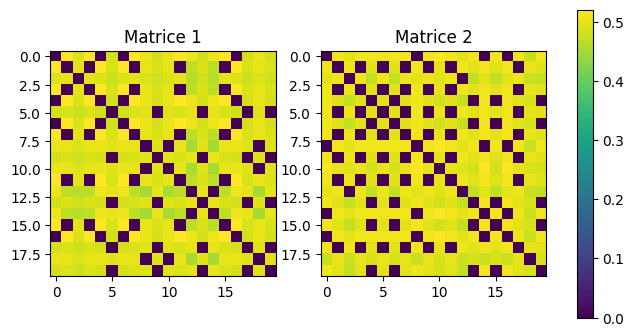

-------------------------------------
Problem 2:
Best: [1 0 1 0 1]...	fitness:0.2243	calls:20
Best: [1 0 0 1 0]...	fitness:0.2303	calls:20
Best: [1 1 1 1 1]...	fitness:0.2325	calls:20
Best: [0 1 1 0 0]...	fitness:0.2336	calls:20
Best: [0 1 1 0 0]...	fitness:0.2394	calls:20
Best: [0 1 0 1 0]...	fitness:0.2415	calls:20
Best: [0 0 0 0 0]...	fitness:0.2485	calls:20
Best: [1 0 1 1 0]...	fitness:0.5	calls:20
(MOST DIFFERENT):	12, 14	(without fitness)
(INDIVIDUALS SELECTED):	12, 11	(with fitness)
Best: [0 0 1 0 0]...	fitness:0.51	calls:40


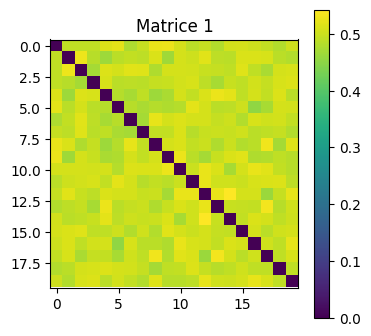

-------------------------------------
Problem 5:
Best: [1 0 0 1 1]...	fitness:0.09406229999999999	calls:20
Best: [1 0 0 0 0]...	fitness:0.0988306	calls:20
Best: [0 1 0 0 0]...	fitness:0.20473	calls:20
(MOST DIFFERENT):	2, 6	(without fitness)
(INDIVIDUALS SELECTED):	2, 6	(with fitness)
Best: [1 1 0 0 1]...	fitness:0.21008500000000002	calls:60
(MOST DIFFERENT):	0, 4	(without fitness)
(INDIVIDUALS SELECTED):	0, 4	(with fitness)
Best: [1 1 0 1 0]...	fitness:0.29208	calls:340


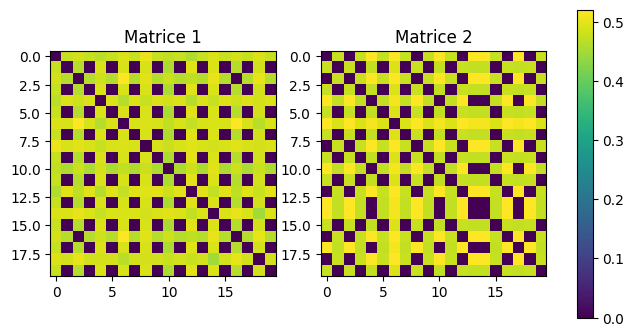

-------------------------------------
Problem 10:
Best: [1 0 1 1 1]...	fitness:0.04989445679499999	calls:20
Best: [1 1 0 0 0]...	fitness:0.054004466806	calls:20
Best: [1 0 1 1 0]...	fitness:0.11189346897	calls:20
Best: [0 1 0 1 1]...	fitness:0.17356157049999998	calls:20
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [0 0 1 0 0]...	fitness:0.21015680699999997	calls:740


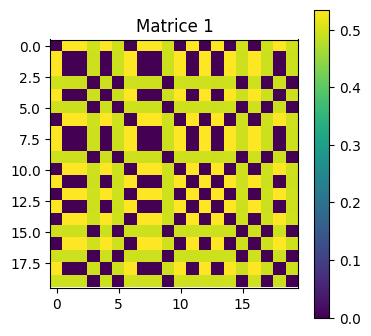

-------------------------------------
Problem	1:	54.80%,	Calls:	2020,	Best found at 	180 fitness calls,	at iteration 8
Problem	2:	51.00%,	Calls:	2020,	Best found at 	40 fitness calls,	at iteration 1
Problem	5:	29.21%,	Calls:	2020,	Best found at 	340 fitness calls,	at iteration 16
Problem	10:	21.02%,	Calls:	2020,	Best found at 	740 fitness calls,	at iteration 36
-------------------------------------


In [80]:
my_list = list()
found = -1
fitness = None
for prob in problems:
    print(f"Problem {prob}:")
    fitness = lab9_lib.make_problem(prob)
    b, found, i = genetic_algorithm(fitness, diversity_selection, crossover_cyclic_shift)
    my_list.append((prob, b[1], fitness.calls, found, i))
    print("-------------------------------------")

for m in my_list:
    print(f"Problem\t{m[0]}:\t{m[1]:.2%},\tCalls:\t{m[2]},\tBest found at \t{m[3]} fitness calls,\tat iteration {m[4]}")
print("-------------------------------------")

### Using STD CROSSOVER and Std selection with replacement:

Problem 1:
Best: [0 0 1 0 1]...	fitness:0.506	calls:20
Best: [0 1 1 0 0]...	fitness:0.536	calls:20
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [0 0 1 1 1]...	fitness:0.546	calls:60


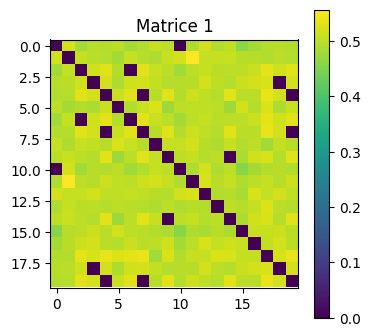

-------------------------------------
Problem 2:
Best: [0 1 1 0 1]...	fitness:0.2303	calls:20
Best: [1 1 0 0 1]...	fitness:0.2365	calls:20
Best: [0 1 0 1 0]...	fitness:0.2368	calls:20
Best: [0 0 1 0 1]...	fitness:0.2397	calls:20
Best: [0 0 0 0 1]...	fitness:0.24230000000000002	calls:20
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [0 0 1 1 1]...	fitness:0.472	calls:40
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [1 0 0 0 0]...	fitness:0.52	calls:60


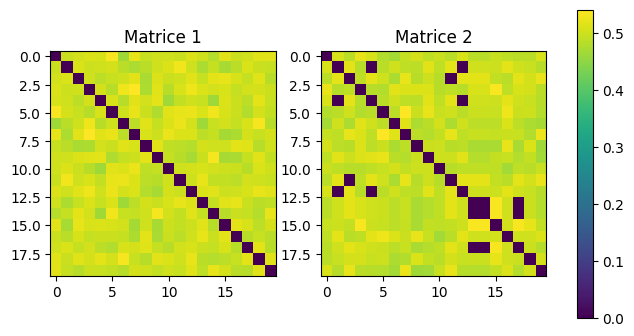

-------------------------------------
Problem 5:
Best: [0 1 0 0 1]...	fitness:0.0960094	calls:20
Best: [0 0 1 1 1]...	fitness:0.0979499	calls:20
Best: [1 1 1 0 0]...	fitness:0.09824809999999999	calls:20
Best: [0 1 0 0 1]...	fitness:0.10039359999999999	calls:20
Best: [0 0 0 1 1]...	fitness:0.10208400000000001	calls:20
Best: [1 0 1 0 1]...	fitness:0.1060415	calls:20
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [1 1 0 1 0]...	fitness:0.195356	calls:40
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [0 1 1 1 0]...	fitness:0.208519	calls:100
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [1 0 0 1 0]...	fitness:0.21268199999999998	calls:1120
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [1 1 1 1 1]...	fitness:0.28637999999999997	calls:1440


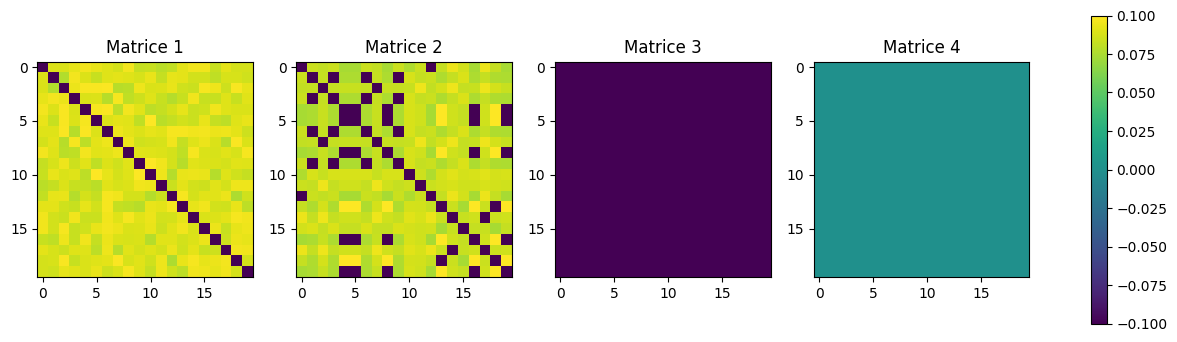

-------------------------------------
Problem 10:
Best: [0 1 0 1 0]...	fitness:0.049901234568	calls:20
Best: [0 1 1 0 0]...	fitness:0.053894469006	calls:20
Best: [1 1 1 0 0]...	fitness:0.056312467797	calls:20
Best: [0 1 0 0 0]...	fitness:0.10023461238999999	calls:20
Best: [0 0 0 1 0]...	fitness:0.10593456797	calls:20
Best: [0 1 0 1 1]...	fitness:0.11189113453999999	calls:20
Best: [0 1 1 0 0]...	fitness:0.11222680024000001	calls:20
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [0 0 1 0 0]...	fitness:0.1649114608	calls:40
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 0	(with fitness)
Best: [0 1 1 0 0]...	fitness:0.16791138960000002	calls:140


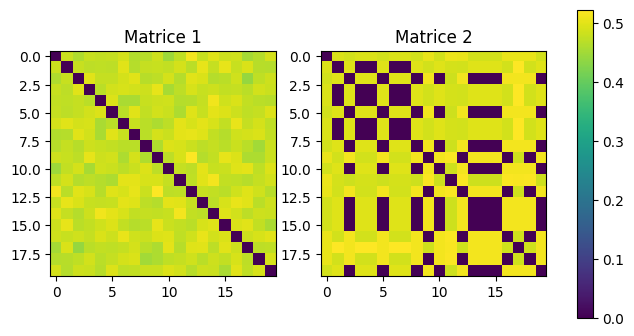

-------------------------------------
Problem	1:	54.60%,	Calls:	2020,	Best found at 	60 fitness calls,	at iteration 2
Problem	2:	52.00%,	Calls:	2020,	Best found at 	60 fitness calls,	at iteration 2
Problem	5:	28.64%,	Calls:	2020,	Best found at 	1440 fitness calls,	at iteration 71
Problem	10:	16.79%,	Calls:	2020,	Best found at 	140 fitness calls,	at iteration 6
-------------------------------------


In [81]:
my_list = list()
found = -1
fitness = None
for prob in problems:
    print(f"Problem {prob}:")
    fitness = lab9_lib.make_problem(prob)
    b, found, i = genetic_algorithm(fitness, select_with_replacement, std_crossover)
    my_list.append((prob, b[1], fitness.calls, found, i))
    print("-------------------------------------")

for m in my_list:
    print(f"Problem\t{m[0]}:\t{m[1]:.2%},\tCalls:\t{m[2]},\tBest found at \t{m[3]} fitness calls,\tat iteration {m[4]}")
print("-------------------------------------")

In [82]:
for i, prob in enumerate(problems):
    print(f"Problem {prob}:")

    fitness = lab9_lib.make_problem(prob)
    for n in range(10):
        ind = choices([0, 1], k=1000)
        print(f"{''.join(str(g) for g in ind[0:5])}... | {fitness(ind):.2%}")

    print(fitness.calls)

    print("-------------------------------------")


Problem 1:
01110... | 49.50%
00100... | 51.40%
10111... | 48.50%
01101... | 47.80%
10101... | 51.80%
00001... | 49.60%
01111... | 50.60%
01001... | 52.50%
11101... | 46.40%
10110... | 51.10%
10
-------------------------------------
Problem 2:
01010... | 23.21%
10010... | 21.78%
11010... | 23.65%
01001... | 21.54%
01100... | 25.09%
10110... | 23.00%
10110... | 22.75%
11010... | 23.08%
00111... | 21.66%
11010... | 20.88%
10
-------------------------------------
Problem 5:
10101... | 9.89%
11101... | 9.44%
00000... | 10.28%
01001... | 9.37%
10011... | 9.26%
00011... | 9.69%
11111... | 10.26%
11101... | 10.05%
00111... | 9.60%
10111... | 9.92%
10
-------------------------------------
Problem 10:
11110... | 5.48%
00011... | 5.89%
10100... | 5.39%
10111... | 5.01%
01110... | 5.37%
01001... | 5.29%
00100... | 4.81%
01001... | 5.55%
00011... | 5.69%
00001... | 5.08%
10
-------------------------------------


In [83]:
fitness = lab9_lib.make_problem(1)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

00110010100100110000111111110010110111110101100100: 54.00%
00001000111010010110110111011100011100000011011011: 50.00%
00111111101101111011100111111110110110000111100011: 68.00%
11100100100110001110110001011111001011001000001010: 48.00%
11100000011010001010101010000111000101010100101100: 42.00%
11101011111101011001011011111011000110000101011001: 60.00%
11100101100110001101000110110001011110100011111101: 56.00%
10100000100110001001000001101011000011010010111110: 42.00%
11100110100000110011000100011111000010001101010010: 44.00%
10010101000101000000100110101010011111111010110100: 48.00%
10


Population number 0
Best: [0 0 0 1 0]...	fitness:0.511	calls:4
Best: [1 1 1 0 1]...	fitness:0.514	calls:4
Population number 1
Best: [0 1 1 1 1]...	fitness:0.471	calls:8
Best: [1 1 1 1 0]...	fitness:0.529	calls:8


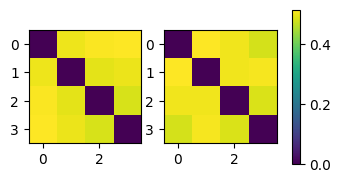

Population number 1
Best: [0 1 0 0 0]...	fitness:0.511	calls:12
Best: [1 1 1 0 0]...	fitness:0.53	calls:12
Population number 0
Best: [1 1 0 1 1]...	fitness:0.486	calls:16
Best: [0 1 0 1 1]...	fitness:0.504	calls:16


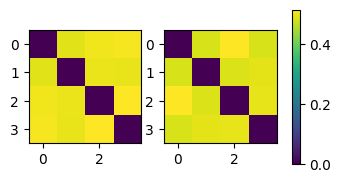

Population number 0
Best: [0 0 0 1 0]...	fitness:0.472	calls:20
Best: [1 0 1 1 1]...	fitness:0.481	calls:20
Population number 1
Best: [1 1 1 1 0]...	fitness:0.513	calls:24


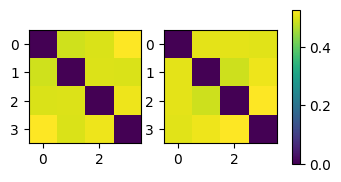

Population number 1
Best: [0 0 0 1 1]...	fitness:0.501	calls:28
Best: [0 1 1 0 1]...	fitness:0.503	calls:28
Population number 0
Best: [0 0 1 1 0]...	fitness:0.481	calls:32
Best: [1 1 0 1 0]...	fitness:0.516	calls:32


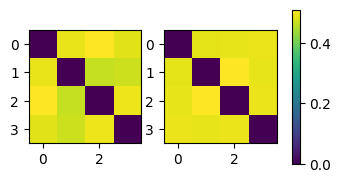

Population number 0
Best: [1 1 0 0 0]...	fitness:0.518	calls:36
Population number 1
Best: [1 0 1 0 0]...	fitness:0.489	calls:40
Best: [1 1 0 0 1]...	fitness:0.502	calls:40


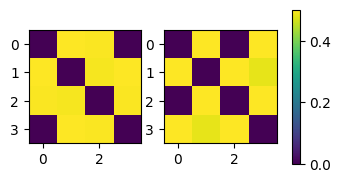

Population number 1
Best: [0 1 1 0 0]...	fitness:0.488	calls:44
Best: [1 0 1 1 1]...	fitness:0.518	calls:44
Population number 0
Best: [1 0 1 1 0]...	fitness:0.51	calls:48


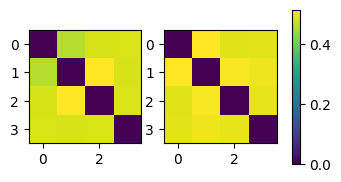

Population number 0
Best: [1 0 1 1 0]...	fitness:0.494	calls:52
Best: [1 0 1 1 0]...	fitness:0.508	calls:52
Population number 1
Best: [1 1 0 1 0]...	fitness:0.511	calls:56


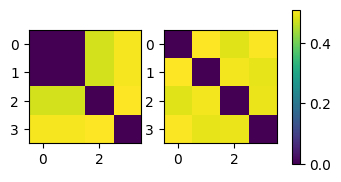

Population number 1
Best: [0 1 0 0 1]...	fitness:0.48	calls:60
Best: [0 0 1 1 0]...	fitness:0.49	calls:60
Population number 0
Best: [0 0 0 0 0]...	fitness:0.501	calls:64
Best: [1 1 0 1 1]...	fitness:0.518	calls:64


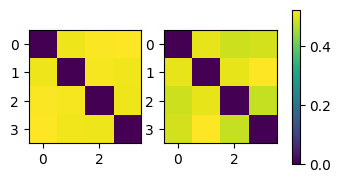

Population number 0
Best: [1 0 0 1 1]...	fitness:0.507	calls:68
Best: [1 1 0 0 1]...	fitness:0.519	calls:68
Population number 1
Best: [1 0 0 0 1]...	fitness:0.497	calls:72
Best: [1 0 1 0 0]...	fitness:0.512	calls:72


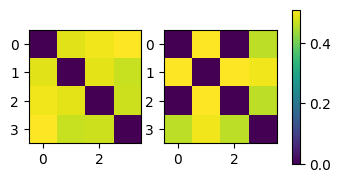

Population number 1
Best: [1 1 1 1 1]...	fitness:0.483	calls:76
Best: [1 0 0 1 0]...	fitness:0.491	calls:76
Population number 0
Best: [0 1 1 1 0]...	fitness:0.508	calls:80


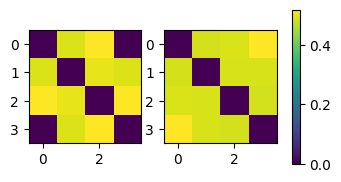

Population number 0
Best: [1 0 1 1 0]...	fitness:0.502	calls:84
Population number 1
Best: [1 1 1 1 1]...	fitness:0.479	calls:88
Best: [1 1 1 0 0]...	fitness:0.492	calls:88
Best: [1 0 1 1 1]...	fitness:0.512	calls:88


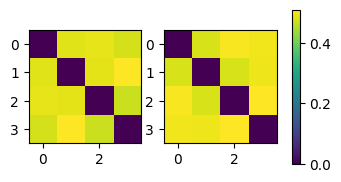

Population number 1
Best: [1 1 1 0 1]...	fitness:0.481	calls:92
Best: [1 0 1 1 1]...	fitness:0.498	calls:92
Population number 0
Best: [1 1 1 1 1]...	fitness:0.487	calls:96
Best: [0 0 0 0 0]...	fitness:0.5	calls:96


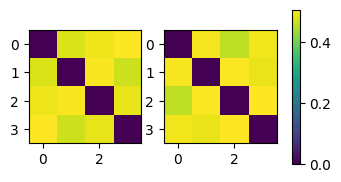

Population number 0
Best: [1 1 1 1 1]...	fitness:0.497	calls:100
Best: [1 1 1 1 0]...	fitness:0.531	calls:100
Population number 1
Best: [0 1 1 0 0]...	fitness:0.474	calls:104
Best: [0 1 0 1 1]...	fitness:0.49	calls:104
Best: [0 1 1 1 1]...	fitness:0.491	calls:104


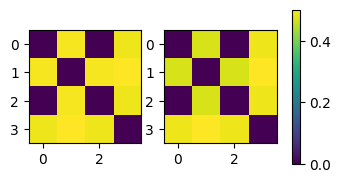

Population number 1
Best: [0 0 0 1 0]...	fitness:0.506	calls:108
Population number 0
Best: [0 0 1 1 0]...	fitness:0.514	calls:112


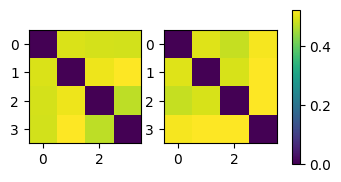

Population number 0
Best: [0 1 1 0 1]...	fitness:0.528	calls:116
Population number 1
Best: [0 0 1 0 1]...	fitness:0.5	calls:120


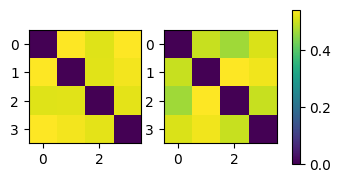

Population number 1
Best: [1 0 0 0 1]...	fitness:0.491	calls:124
Best: [0 0 1 0 1]...	fitness:0.514	calls:124
Population number 0
Best: [0 1 1 1 0]...	fitness:0.526	calls:128


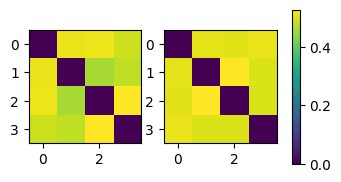

Population number 0
Best: [0 0 0 0 0]...	fitness:0.511	calls:132
Best: [0 0 0 1 1]...	fitness:0.528	calls:132
Population number 1
Best: [0 0 0 0 0]...	fitness:0.509	calls:136
Best: [1 0 1 1 0]...	fitness:0.534	calls:136


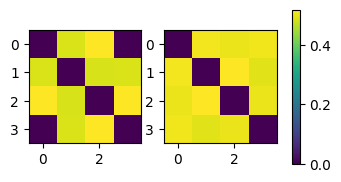

Population number 1
Best: [0 0 0 1 1]...	fitness:0.476	calls:140
Best: [0 0 1 0 0]...	fitness:0.499	calls:140
Best: [0 0 1 1 0]...	fitness:0.505	calls:140
Population number 0
Best: [0 1 0 0 0]...	fitness:0.509	calls:144


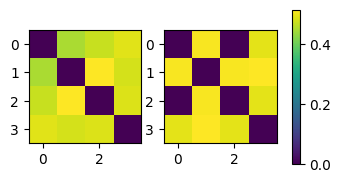

Population number 0
Best: [1 1 0 0 0]...	fitness:0.516	calls:148
Best: [0 1 1 0 1]...	fitness:0.522	calls:148
Population number 1
Best: [0 1 1 1 0]...	fitness:0.458	calls:152
Best: [1 1 0 1 1]...	fitness:0.502	calls:152


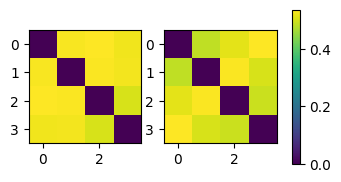

Population number 1
Best: [1 1 0 1 0]...	fitness:0.514	calls:156
Best: [0 0 1 1 0]...	fitness:0.527	calls:156
Population number 0
Best: [0 1 0 1 0]...	fitness:0.491	calls:160
Best: [0 0 1 1 1]...	fitness:0.498	calls:160


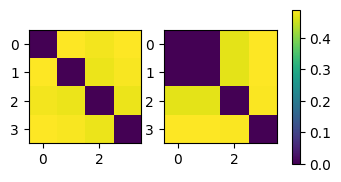

Problem 1:160


In [93]:
µ = 4
def plot_diff(diff_matrix, diff_matrix_2):
  fig, axes = plt.subplots(1, 2, figsize=(4, 2))
  im = axes[0].imshow(diff_matrix, cmap='viridis')
  im = axes[1].imshow(diff_matrix_2, cmap='viridis')
  fig.colorbar(im, ax=axes, orientation='vertical')    
  plt.show()

def diversity_selection_2(population, diff_matrix):
    # find the individuals with 
    # the highest fitness and the highest diversity
    div_matr = np.zeros((µ, µ))
    for i1, p1 in enumerate(population):
        for i2, p2 in enumerate(population):
            if i1 != i2:
                #the matrix is not symmetric since is added only for p2[1]
                div_matr[i1][i2] = (compute_diversity(p1[0], p2[0]) + p2[1]) / 2
                diff_matrix[i1][i2] = compute_diversity(p1[0], p2[0])

    # find index of the individuals with highest fitness and highest diversity
    i1, i2 = np.unravel_index(np.argmax(div_matr), div_matr.shape)
    return population[i1], population[i2]

def evolve(population, fitness, diff_matrix, pop_numb):
  Best = None
  q = list()
  for _ in range(µ//2):
      # 2.1 Select parents
      parent_a, parent_b = diversity_selection_2(population, diff_matrix)
      # 2.2 Crossover
      child_a, child_b = crossover_cyclic_shift(copy(parent_a), copy(parent_b))
      # 2.3 Mutate
      mutated_a = mutate(child_a)
      mutated_b = mutate(child_b)
      q.append(mutated_a)
      q.append(mutated_b)
  population = evaluate_population(q, fitness)
  print(f"Population number {pop_numb}")
  for p in population:
    if Best is None or p[1] > Best[1]:
      print(f"Best: {p[0][0:5]}...\tfitness:{p[1]}\tcalls:{fitness._calls}")
      Best = p
  return Best

def island_method(fitness, n_islands=2):
  populations = []
  Best = None
  diff_matrices = []
  for _ in range(n_islands):
    diff_matrices.append(np.zeros((µ, µ)))
    populations.append(init_population())

  for _ in range(10):
    for i in range(n_islands):
       for j in range(n_islands):
          if i != j:
             i1, i2 = evolve(populations[i], fitness, diff_matrices[i], i), evolve(populations[j], fitness, diff_matrices[j], j)
             plot_diff(diff_matrices[i], diff_matrices[j])
             populations[i][0], populations[j][0] = i2, i1
             Best = max(i1[1], i2[1])
  return Best

fitness = lab9_lib.make_problem(1)
b = island_method(fitness)
print(f"Problem 1:{fitness.calls}")
